In [1]:
import torch
import itertools
import numpy as np
%load_ext autoreload
%autoreload 2

# Emulating the DRP Object Catalog

### Global config

In [25]:
import json

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device=='cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

args = json.load(open("args.txt"))

### Data I/O

In [3]:
from derp_data import DerpData
from torch.utils.data import DataLoader

# X base columns
truth_cols = list('ugriz') + ['y_truth', 'ra_truth', 'dec_truth', 'redshift', 'star',]
truth_cols += ['size_bulge_true', 'size_minor_bulge_true', 'ellipticity_1_bulge_true', 'ellipticity_2_bulge_true', 'bulge_to_total_ratio_i']
truth_cols += ['size_disk_true', 'size_minor_disk_true', 'ellipticity_1_disk_true', 'ellipticity_2_disk_true',]
opsim_cols = ['m5_flux', 'PSF_sigma2', 'filtSkyBrightness_flux', 'airmass']
# Y base columns
drp_cols = ['x', 'y_obs', 'ra_obs', 'dec_obs', 'Ixx', 'Ixy', 'Iyy', 'IxxPSF', 'IxyPSF', 'IyyPSF',] #'extendedness',]
drp_cols_prefix = ['cModelFlux_', 'psFlux_']
drp_cols_suffix = ['_base_CircularApertureFlux_70_0_instFlux','_ext_photometryKron_KronFlux_instFlux',]
drp_cols += [t[0] + t[1] for t in list(itertools.product(drp_cols_prefix, list('ugrizy')))]
drp_cols += [t[1] + t[0] for t in list(itertools.product(drp_cols_suffix, list('ugrizy')))]

# Define dataset
data = DerpData(data_path=args['data_path'], X_base_cols=truth_cols + opsim_cols, Y_base_cols=drp_cols, train_frac=args['train_frac'],
                    ignore_null_rows=True, verbose=args['verbose'], save_to_disk=False)
X_cols = data.X_cols
Y_cols = data.Y_cols
X_cat_mapping = data.X_cat_mapping
n_trainval = data.n_trainval
n_train = data.n_train
n_val = n_trainval - n_train
X_dim = data.X_dim
Y_dim = data.Y_dim

/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Deleting null rows: 85049 --> 79318
Standardized X except:  ['not_star']
Standardized Y except:  []
Saving processed data to disk...


In [14]:
from torch.utils.data.sampler import SubsetRandomSampler

# Split train vs. val
train_sampler = SubsetRandomSampler(data.train_indices)
val_sampler = SubsetRandomSampler(data.val_indices)

# Define dataloader
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}
train_loader = DataLoader(data, batch_size=args['batch_size'], sampler=train_sampler, **kwargs)
val_loader = DataLoader(data, batch_size=args['batch_size'], sampler=val_sampler, **kwargs)

In [15]:
for batch_idx, (X_batch, Y_batch) in enumerate(val_loader):
    print(X_batch.shape)
    print(Y_batch.shape)
    break

torch.Size([1000, 23])
torch.Size([1000, 34])


### Model

In [26]:
from models import ConcreteDense

length_scale = args['l']
wr = length_scale**2.0/n_train
dr = 2.0/n_train
model = ConcreteDense(X_dim, Y_dim, args['n_features'], wr, dr)

### Training

In [57]:
from optim import fit_model

X_val = data.X[data.val_indices, :]
Y_val = data.Y[data.val_indices, :]
model, pppp, rmse = fit_model(model, args['n_epochs'], train_loader, val_loader, n_val,
                             device=device, logging_interval=args['logging_interval'],
                             X_val=X_val, Y_val=Y_val, n_MC=args['n_MC'])

Epoch 10 done
Epoch 20 done
Epoch 30 done
Epoch 40 done
Epoch 50 done
Epoch 60 done
Epoch 70 done
Epoch 80 done
Epoch 90 done
Epoch 100 done


Text(0.5, 1.0, 'Validation likelihood')

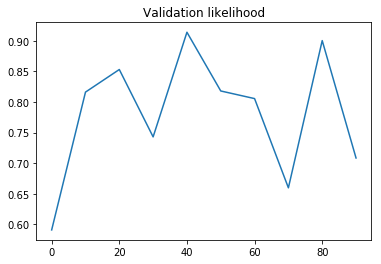

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(0, args['n_epochs'], args['logging_interval']),
         rmse)
plt.title("Validation likelihood")

Text(0.5, 1.0, 'Validation likelihood')

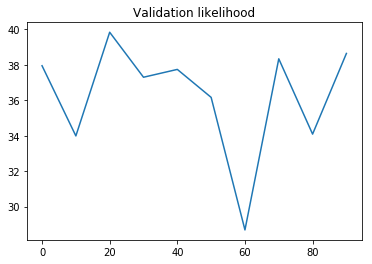

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(0, args['n_epochs'], args['logging_interval']),
         pppp)
plt.title("Validation likelihood")

### Prediction

In [61]:
from torch.autograd import Variable

model.eval()
MC_samples = [model(Variable(torch.FloatTensor(X_val)).to(device)) for _ in range(args['n_MC'])]

In [62]:
means = torch.stack([tup[0] for tup in MC_samples]).view(args['n_MC'], n_val, Y_dim).cpu().data.numpy()
logvar = torch.stack([tup[1] for tup in MC_samples]).view(args['n_MC'], n_val, Y_dim).cpu().data.numpy()
np.save("means_run_%d" %args['run_id'], means.reshape(args['n_MC'], -1))
np.save("logvar_run_%d"%args['run_id'], logvar.reshape(args['n_MC'], -1))
data.export_metadata_for_eval()